# INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS

In [392]:
!pip install pmdarima

In [393]:
import pandas as pd
import numpy as np
import os
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima.arima.stationarity import ADFTest, KPSSTest, PPTest
from pmdarima.arima.utils import ndiffs
from pmdarima.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import STL

# AQUISIÇÃO E PRÉ-PROCESSAMENTO

In [394]:
def baixar_arquivos_csv_github(usuario, repositorio, pasta):
    # URL da API do GitHub para obter o conteúdo da pasta
    url_api = f'https://api.github.com/repos/{usuario}/{repositorio}/contents/{pasta}'

    # Requisição GET para obter o conteúdo da pasta
    response = requests.get(url_api)

    # Verificar se a requisição foi bem-sucedida
    if response.status_code == 200:
        # Converter a resposta para JSON
        conteudo_pasta = response.json()

        # Lista para armazenar os caminhos dos arquivos CSV
        caminhos_arquivos_csv = []

        # Criar o diretório para armazenar os arquivos temporários, se não existir
        if not os.path.exists('arquivos_temporarios'):
            os.makedirs('arquivos_temporarios')

        # Iterar sobre o conteúdo da pasta
        for arquivo in conteudo_pasta:
            # Verificar se o item é um arquivo
            if arquivo['type'] == 'file' and arquivo['name'].endswith('.csv'):
                # Baixar o arquivo
                url_arquivo = arquivo['download_url']
                response_arquivo = requests.get(url_arquivo)

                # Verificar se a requisição foi bem-sucedida
                if response_arquivo.status_code == 200:
                    # Salvar o arquivo localmente
                    nome_arquivo = arquivo['name']
                    caminho_arquivo = os.path.join('arquivos_temporarios', nome_arquivo)
                    with open(caminho_arquivo, 'wb') as f:
                        f.write(response_arquivo.content)

                    # Adicionar o caminho do arquivo à lista
                    caminhos_arquivos_csv.append(caminho_arquivo)

        return caminhos_arquivos_csv
    else:
        print(f'Erro ao obter conteúdo da pasta. Código de status: {response.status_code}')
        return []

def consolidar_dados_por_dia(caminhos_arquivos):
    dados_consolidados_mensais = []

    for caminho_arquivo in caminhos_arquivos:
        # Ler o arquivo CSV
        dados = pd.read_csv(caminho_arquivo, encoding='latin-1', sep=';').drop(columns=['Hora (UTC)', 'Pressao (hPa)', 'Insolacao (h)','Dir. Vento (m/s)'])

        # Interpretar a coluna 'Data' como data
        dados['Data'] = pd.to_datetime(dados['ï»¿"Data"'], format='%d/%m/%Y')

        # Substituir vírgulas por pontos e converter para tipo numérico
        colunas_numericas = ['Temp. [Hora] (C)', 'Umi. (%)', 'Vel. Vento (m/s)',
                             'Nebulosidade (Decimos)',
                             'Temp. Max. [Diaria] (h)', 'Temp. Min. [Diaria] (h)',
                             'Chuva [Diaria] (mm)']
        for coluna in colunas_numericas:
            dados[coluna] = dados[coluna].str.replace(',', '.').astype(float)

        # Excluir coluna de data
        dados = dados.drop(columns=['ï»¿"Data"'])

        # Consolidar os dados por data, calculando a média para cada coluna numérica
        dados_consolidados = dados.groupby('Data').mean()

        # Definir o índice como um DatetimeIndex
        dados_consolidados.index = pd.to_datetime(dados_consolidados.index)

        # Agrupar os dados por mês e calcular as médias mensais
        dados_consolidados_mensais.append(dados_consolidados.resample('M').mean())

    # Concatenar todos os dados consolidados mensais
    dados_consolidados_mensais = pd.concat(dados_consolidados_mensais)

    # Formatar a data para mostrar apenas o mês e o ano
    dados_consolidados_mensais.index = dados_consolidados_mensais.index.strftime('%Y-%m')

    # Arredondar os valores para duas casas decimais
    dados_consolidados_mensais = dados_consolidados_mensais.round(2)

    # Renomear colunas
    dados_consolidados_mensais = dados_consolidados_mensais.rename(columns={
        'Temp. [Hora] (C)': 'Temperatura (C)',
        'Umi. (%)': 'Umidade (%)',
        'Vel. Vento (m/s)': 'Velocidade do Vento (m/s)',
        'Nebulosidade (Decimos)': 'Nebulosidade (Decimos)',
        'Temp. Max. [Diaria] (h)': 'Temperatura Máxima (C)',
        'Temp. Min. [Diaria] (h)': 'Temperatura Mínima (C)',
        'Chuva [Diaria] (mm)': 'Chuva (mm)'
    })

    return dados_consolidados_mensais

# Informações do repositório GitHub
usuario = 'PedroCosDi'
repositorio = 'p4dataedgeflow'
pasta = 'DadosINMET/ACRE'

# Baixar os arquivos CSV da pasta do GitHub
caminhos_arquivos = baixar_arquivos_csv_github(usuario, repositorio, pasta)

# Consolidar os dados mensais de todos os estados
dados_consolidados_mensais = consolidar_dados_por_dia(caminhos_arquivos)

# Exibir os dados consolidados mensais
print(dados_consolidados_mensais.head())

         Temperatura (C)  Umidade (%)  Velocidade do Vento (m/s)  \
Data                                                               
2019-08            26.53        74.62                       0.68   
2019-09            25.92        87.35                       0.22   
2019-10            24.94        91.09                       0.31   
2019-11            26.94        84.79                       0.81   
2019-12            26.80        84.87                       0.66   

         Nebulosidade (Decimos)  Temperatura Máxima (C)  \
Data                                                      
2019-08                    4.78                   33.22   
2019-09                    6.90                   34.35   
2019-10                    8.47                   32.06   
2019-11                    8.26                   32.13   
2019-12                    8.22                   31.56   

         Temperatura Mínima (C)  Chuva (mm)  
Data                                         
2019-08          

In [395]:
url = 'https://raw.githubusercontent.com/PedroCosDi/p4dataedgeflow/main/queimadas.csv'
df = pd.read_csv(url, encoding='ISO-8859-1', sep=';')
df.rename(columns={'date': 'Data'}, inplace=True)
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)
# Ordenar o DataFrame pelo índice (data)
df.sort_index(inplace=True)

<ipython-input-395-7d53c25bbb3e>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Data'] = pd.to_datetime(df['Data'])


In [396]:
# Remover a coluna 'class' do DataFrame completo
df_sem_class = df.drop(columns=['class'])

# Agrupar o DataFrame sem a coluna 'class' por estado e data, somando os valores da coluna 'focuses'
df_agrupado = df_sem_class.groupby(['uf', 'Data']).sum()

# Definir 'Data' como índice
df_agrupado.reset_index(inplace=True)
df_agrupado.set_index('Data', inplace=True)

# Ordenar os valores por data
df_agrupado.sort_index(inplace=True)

# Separar os DataFrames por estado
dataframes_por_estado = {}
for estado, grupo in df_agrupado.groupby('uf'):
    # Remover a coluna 'uf'
    grupo.drop(columns=['uf'], inplace=True)

    dataframes_por_estado[estado] = grupo

# Atribuir DataFrames a variáveis separadas, os outros estados vão ser implementados depois
df_acre = dataframes_por_estado.get('ACRE')
df_amapa = dataframes_por_estado.get('AMAPÁ')
df_amazonas = dataframes_por_estado.get('AMAZONAS')
df_mato_grosso = dataframes_por_estado.get('MATO GROSSO')
df_rondonia = dataframes_por_estado.get('RONDÔNIA')
df_roraima = dataframes_por_estado.get('RORAIMA')
df_maranhao = dataframes_por_estado.get('MARANHÃO')
df_tocantins = dataframes_por_estado.get('TOCANTINS')
df_para = dataframes_por_estado.get('PARÁ')

In [397]:
# Resetar o índice para manter 'date' como uma coluna regular
df_acre.reset_index(inplace=True)

# Converter a coluna 'date' para o formato de período mensal
df_acre['Data'] = df_acre['Data'].dt.to_period('M')

# Definir a coluna 'date' como índice novamente
df_acre.set_index('Data', inplace=True)

In [398]:
# Resetar o índice para manter 'date' como uma coluna regular
dados_consolidados_mensais.reset_index(inplace=True)

# Converter a coluna 'date' para o formato de data e hora
dados_consolidados_mensais['Data'] = pd.to_datetime(dados_consolidados_mensais['Data'])

# Converter a coluna 'date' para o formato de período mensal
dados_consolidados_mensais['Data'] = dados_consolidados_mensais['Data'].dt.to_period('M')

# Definir a coluna 'date' como índice novamente
dados_consolidados_mensais.set_index('Data', inplace=True)

In [399]:
# Criar um índice com todos os meses desejados
todos_meses = pd.period_range(start=df_acre.index.min(), end=df_acre.index.max(), freq='M')

# Reindexar o DataFrame para incluir todos os meses e preencher os valores de 'focuses' com NaN
df_acre = df_acre.reindex(todos_meses)

# Preencher os valores de 'focuses' com NaN para os meses recém-criados
df_acre['focuses'] = df_acre['focuses'].replace(0, np.nan)

# Preencher os valores ausentes usando interpolação linear
df_acre['focuses'] = df_acre['focuses'].interpolate(method='linear', limit_direction='both')

In [400]:
# Mesclar os DataFrames usando o índice como chave de mesclagem
df_merged = df_acre.merge(dados_consolidados_mensais, left_index=True, right_index=True)

# Exibir o resultado
print(df_merged.head())
print(df_merged.index)

         focuses  Temperatura (C)  Umidade (%)  Velocidade do Vento (m/s)  \
2019-08   3051.0            26.53        74.62                       0.68   
2019-09   2977.0            25.92        87.35                       0.22   
2019-10    354.0            24.94        91.09                       0.31   
2019-11     44.0            26.94        84.79                       0.81   
2019-12      1.0            26.80        84.87                       0.66   

         Nebulosidade (Decimos)  Temperatura Máxima (C)  \
2019-08                    4.78                   33.22   
2019-09                    6.90                   34.35   
2019-10                    8.47                   32.06   
2019-11                    8.26                   32.13   
2019-12                    8.22                   31.56   

         Temperatura Mínima (C)  Chuva (mm)  
2019-08                   19.44        3.39  
2019-09                   22.90        3.99  
2019-10                   22.98        6.97 

In [401]:
# Inicializar o scaler
scaler = StandardScaler()

# Normalizar os dados
df_scaled_values = scaler.fit_transform(df_merged.values)
df_scaled = pd.DataFrame(df_scaled_values, columns=df_merged.columns, index=df_merged.index)

In [402]:
df_scaled.index = df_scaled.index.to_timestamp()

In [403]:
df_merged.index = df_merged.index.to_timestamp()

In [404]:
train=df_scaled[(df_scaled.index.get_level_values(0) >= '2019-08') & (df_scaled.index.get_level_values(0) <= '2023-02')]
test=df_scaled[(df_scaled.index.get_level_values(0) > '2023-02')]

# SARIMAX

In [405]:
# Lista de testes de estacionariedade
tests = ['adf', 'kpss', 'pp']

# Calcular o número de diferenciações requeridas
d = ndiffs(train['focuses'], test='adf')  # Apenas um teste pode ser usado aqui

# Selecionar as variáveis exógenas
exog_cols = train.drop(['focuses'], axis=1)

# Executar a busca de modelo automático
model = pm.auto_arima(train['focuses'],
                       exogenous=exog_cols,
                       m=12, seasonal=True,
                       start_p=0, start_q=0, max_order=4,
                       d=d,
                       test=tests,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True, trace=True,
                       information_criterion='aic',
                       method='nm',
                       maxiter=20)

# Exibir o melhor modelo
print("Best Model Summary:")
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=41.706, Time=0.12 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=37.749, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=40.883, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=41.078, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=37.944, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=39.377, Time=0.08 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=39.731, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=38.812, Time=0.06 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=39.076, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=40.284, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.768 seconds
Best Model Summary:
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   43
Model:             SARIMAX(0, 1, 0, 12)   Log L

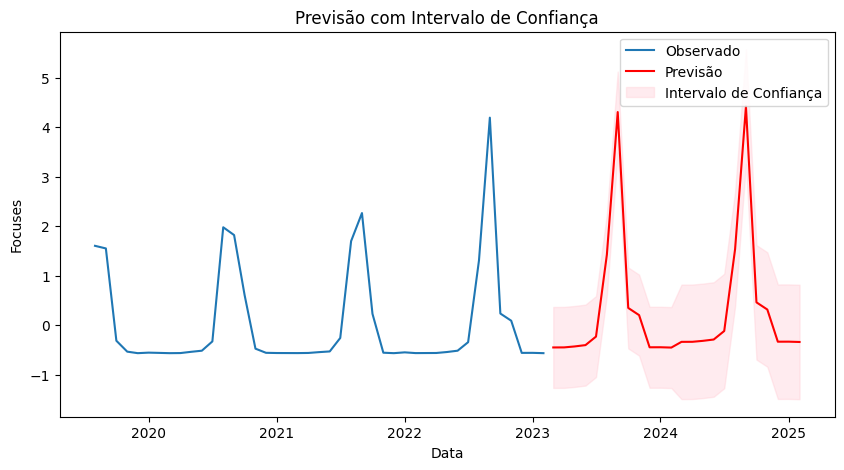

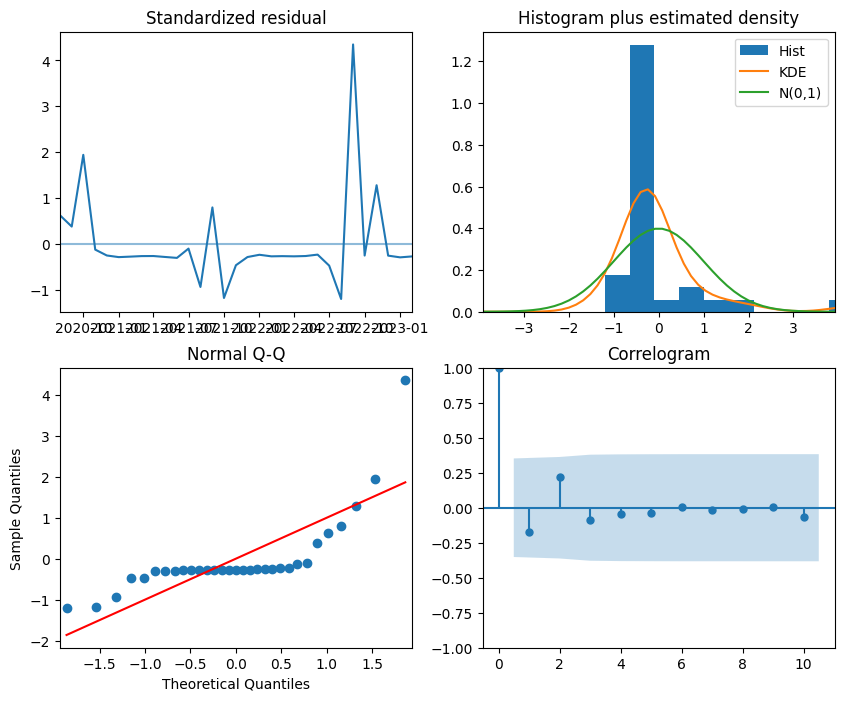

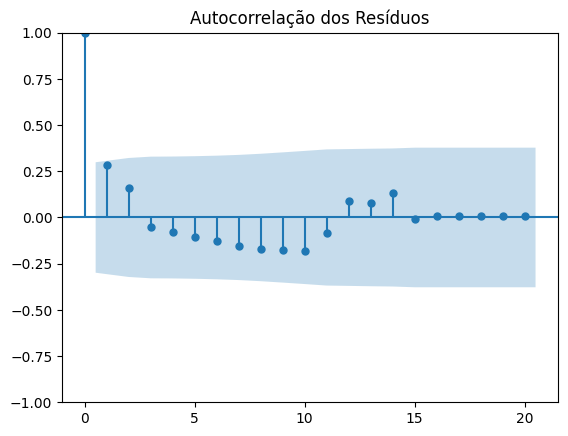

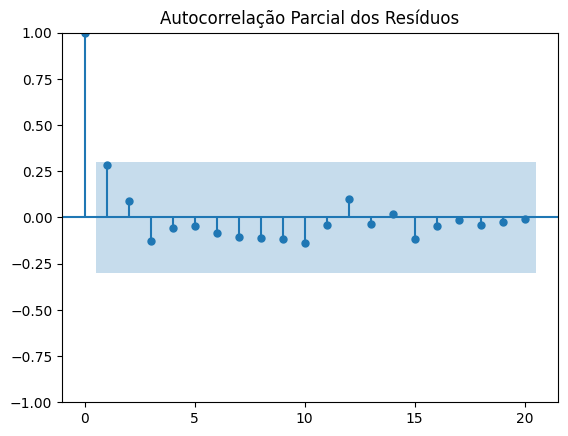

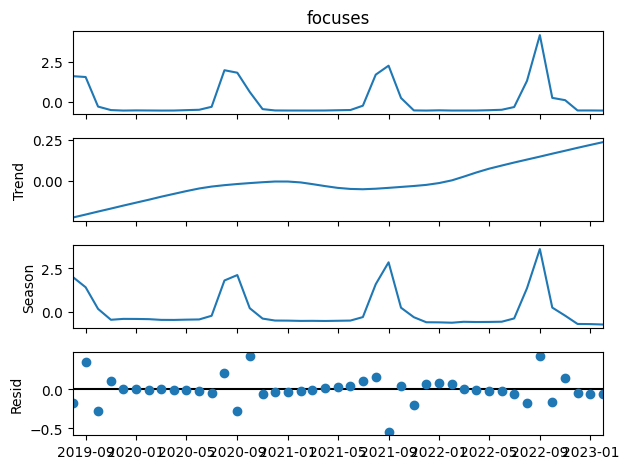

In [406]:
# Ajustar o modelo para fazer previsões
n_periods = 24
forecast, conf_int = model.predict(n_periods=n_periods, exogenous=exog_cols[-n_periods:], return_conf_int=True)

# Criar datas para os períodos de previsão
forecast_index = pd.date_range(start=train.index[-1], periods=n_periods+1, freq='MS')

# Plotar previsões e intervalo de confiança
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['focuses'], label='Observado')
plt.plot(forecast_index[1:], forecast, color='red', label='Previsão')
plt.fill_between(forecast_index[1:], conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.title('Previsão com Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Focuses')
plt.legend()
plt.show()

# Plotar diagnósticos do modelo
model.plot_diagnostics(figsize=(10, 8))
plt.show()

# Plotar autocorrelação e autocorrelação parcial dos resíduos
plot_acf(model.resid(), lags=20)
plt.title('Autocorrelação dos Resíduos')
plt.show()

plot_pacf(model.resid(), lags=20)
plt.title('Autocorrelação Parcial dos Resíduos')
plt.show()

# Plotar decomposição STL (Se sazonalidade for detectada)
from statsmodels.tsa.seasonal import STL

stl = STL(train['focuses'], seasonal=13)
res = stl.fit()

fig = res.plot()
plt.show()

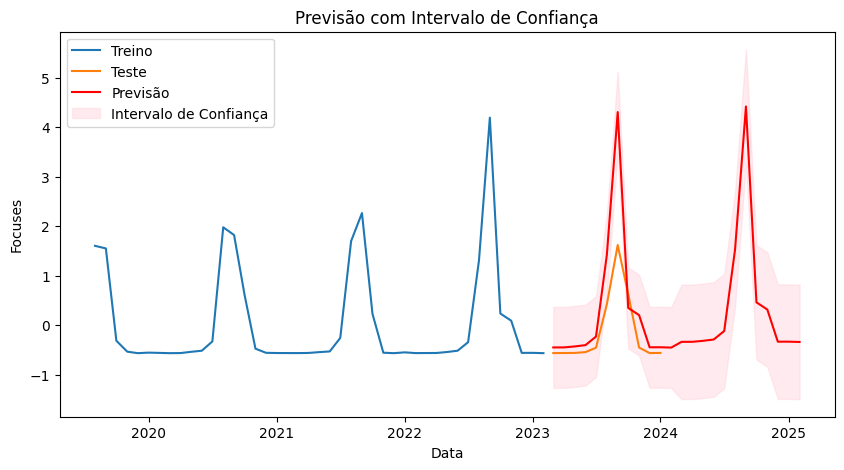

In [407]:
# Plotar previsões e intervalo de confiança
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['focuses'], label='Treino')
plt.plot(test.index, test['focuses'], label='Teste')
plt.plot(forecast_index[1:], forecast, color='red', label='Previsão')
plt.fill_between(forecast_index[1:], conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')
plt.title('Previsão com Intervalo de Confiança')
plt.xlabel('Data')
plt.ylabel('Focuses')
plt.legend()
plt.show()

Formato dos dados:
(43,)

Valores ausentes:
0


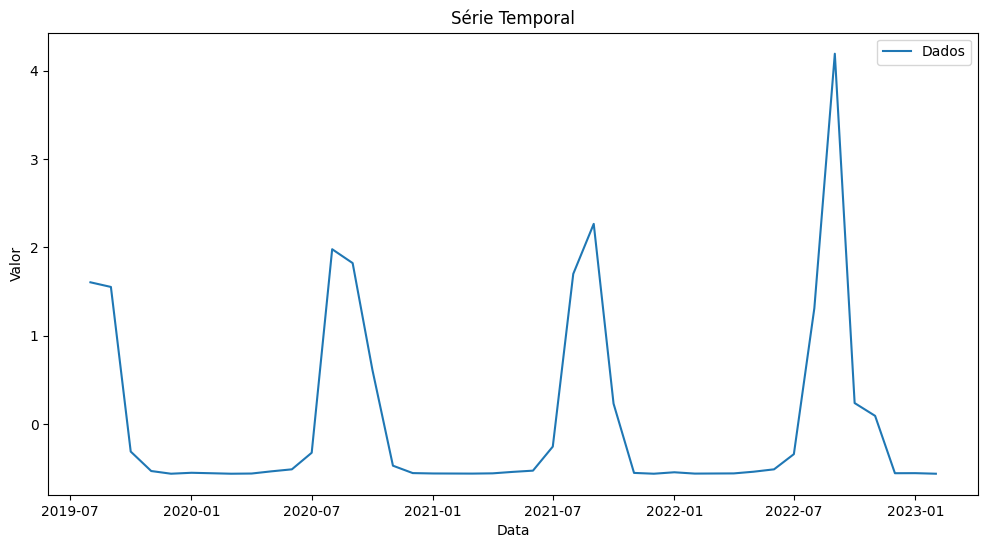

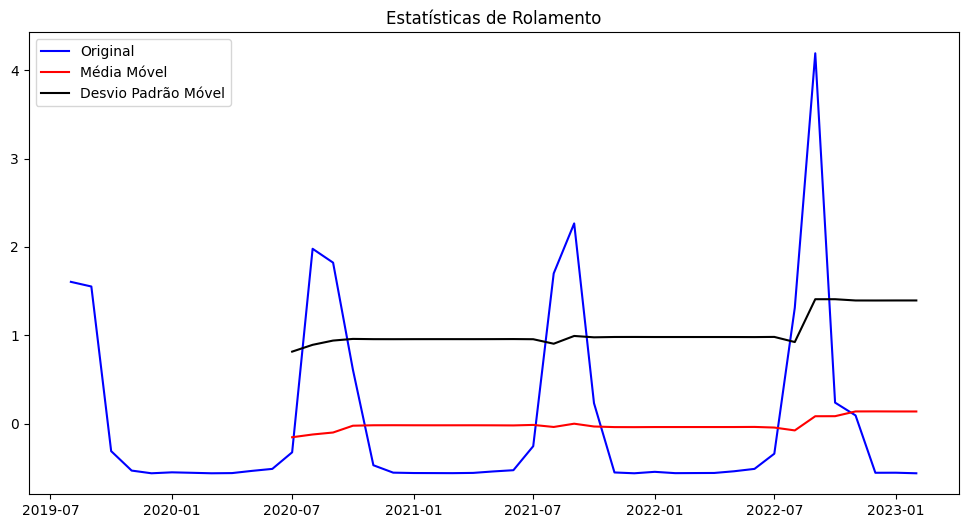

Resultados do Teste Dickey-Fuller:
Estatística do Teste           -7.325388e+00
Valor-p                         1.164706e-10
# de Atrasos Usados             9.000000e+00
Número de Observações Usadas    3.300000e+01
Valor Crítico (1%)             -3.646135e+00
Valor Crítico (5%)             -2.954127e+00
Valor Crítico (10%)            -2.615968e+00
dtype: float64


In [408]:
# Verificar se os dados estão no formato adequado
print("Formato dos dados:")
print(train['focuses'].shape)

# Verificar se há valores ausentes
print("\nValores ausentes:")
print(train['focuses'].isnull().sum())

# Plotar os dados
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['focuses'], label='Dados')
plt.title('Série Temporal')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

# Verificar estacionaridade dos dados
def test_stationarity(timeseries):
    # Estatísticas de rolamento
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plotar estatísticas de rolamento
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Média Móvel')
    plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
    plt.legend()
    plt.title('Estatísticas de Rolamento')
    plt.show()

    # Teste Dickey-Fuller:
    print('Resultados do Teste Dickey-Fuller:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do Teste', 'Valor-p', '# de Atrasos Usados', 'Número de Observações Usadas'])
    for key, value in dftest[4].items():
        dfoutput['Valor Crítico (%s)' % key] = value
    print(dfoutput)

# Executar teste de estacionaridade
test_stationarity(train['focuses'])

In [409]:
# Calcular a matriz de correlação
correlation_matrix = df_merged.corr()

# Selecionar apenas as correlações da variável dependente com as colunas exógenas
correlation_with_target = correlation_matrix['focuses'].drop('focuses')

# Exibir as correlações com a variável dependente
print(correlation_with_target)

Temperatura (C)             -0.146812
Umidade (%)                 -0.235151
Velocidade do Vento (m/s)   -0.419017
Nebulosidade (Decimos)      -0.553981
Temperatura Máxima (C)       0.636309
Temperatura Mínima (C)      -0.316671
Chuva (mm)                  -0.334626
Name: focuses, dtype: float64


# VAR

In [410]:
# Função para diferenciar uma série temporal
def difference_series(series):
    diff_series = series.diff().dropna()
    return diff_series.fillna(method='ffill').fillna(method='bfill')

# Normalização usando StandardScaler para um DataFrame
def standardize_dataframe(df):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Iterar sobre as colunas do DataFrame df_merged
for coluna in df_merged.columns:
    # Aplicar o teste ADF à série temporal na coluna atual
    resultado_adf = adfuller(df_merged[coluna])

    # Extrair os resultados do teste
    estatistica_teste = resultado_adf[0]
    p_valor = resultado_adf[1]
    valores_criticos = resultado_adf[4]

    # Verificar se a série temporal não é estacionária
    if p_valor >= 0.05:
        # Aplicar diferenciação na série temporal
        df_merged[coluna] = difference_series(df_merged[coluna])

# Preencher os valores NaN com a média de cada coluna
df_merged.fillna(df_merged.mean(), inplace=True)

# Normalizar o DataFrame com as colunas diferenciadas e os valores NaN preenchidos
df_merged = standardize_dataframe(df_merged)

# Verificar o DataFrame atualizado, diferenciado, preenchido com a média e padronizado
print(df_merged)

             focuses  Temperatura (C)   Umidade (%)  \
2019-08-01  0.000000    -6.482306e-18 -6.240906e-18   
2019-09-01 -0.012015    -6.040565e-01  2.829661e+00   
2019-10-01 -1.858621    -9.497100e-01  8.082381e-01   
2019-11-01 -0.182984     1.834202e+00 -1.449279e+00   
2019-12-01  0.010443    -1.649830e-01 -1.472146e-02   
2020-01-01  0.052461     5.356661e-01 -6.150772e-01   
2020-02-01  0.036161    -5.012946e-01  7.520250e-01   
2020-03-01  0.036161    -3.611648e-01  1.853971e-01   
2020-04-01  0.043767    -1.061814e+00  1.030842e+00   
2020-05-01  0.066950    -7.628703e-01 -7.792194e-01   
2020-06-01  0.064776     1.713285e-01  1.900639e-02   
2020-07-01  0.232847    -3.518228e-01  1.675786e-02   
2020-08-01  2.390964    -1.551123e-02 -1.611173e+00   
2020-09-01 -0.118508     1.348419e+00  7.407824e-01   
2020-10-01 -1.193582    -1.556939e+00  1.462558e+00   
2020-11-01 -1.061734     2.319986e+00 -1.651646e+00   
2020-12-01 -0.043890    -4.265587e-01 -5.294636e-02   
2021-01-01

In [411]:
# Iterar sobre as colunas do DataFrame df_merged
for coluna in df_merged.columns:
    # Aplicar o teste ADF à série temporal na coluna atual
    resultado_adf = adfuller(df_merged[coluna])

    # Extrair os resultados do teste
    estatistica_teste = resultado_adf[0]
    p_valor = resultado_adf[1]
    valores_criticos = resultado_adf[4]

    # Imprimir os resultados para a coluna atual
    print('Resultados para a coluna:', coluna)
    print('Estatística do teste:', estatistica_teste)
    print('Valor-p:', p_valor)
    print('Valores críticos:', valores_criticos)

    # Verificar se a série temporal é estacionária
    if p_valor < 0.05:
        print('A série temporal é estacionária (rejeita-se a hipótese nula)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar a hipótese nula)')
    print()
  # O Print foi usado para conferir se a diferenciação funcionou

Resultados para a coluna: focuses
Estatística do teste: -6.764663370603324
Valor-p: 2.7364137171521393e-09
Valores críticos: {'1%': -3.596635636000432, '5%': -2.933297331821618, '10%': -2.6049909750566895}
A série temporal é estacionária (rejeita-se a hipótese nula)

Resultados para a coluna: Temperatura (C)
Estatística do teste: -4.428007788454243
Valor-p: 0.0002647267498902803
Valores críticos: {'1%': -3.5812576580093696, '5%': -2.9267849124681518, '10%': -2.6015409829867675}
A série temporal é estacionária (rejeita-se a hipótese nula)

Resultados para a coluna: Umidade (%)
Estatística do teste: -4.363166815725882
Valor-p: 0.00034469982360961954
Valores críticos: {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}
A série temporal é estacionária (rejeita-se a hipótese nula)

Resultados para a coluna: Velocidade do Vento (m/s)
Estatística do teste: -4.7817037260684865
Valor-p: 5.894266039233467e-05
Valores críticos: {'1%': -3.560242358792829, '5%': -2.91785

In [412]:
# Dividir os dados em treinamento e teste
train_size = int(len(df_merged) * 0.8)
train, test = df_merged[:train_size], df_merged[train_size:]

# Selecionar colunas exógenas (todas as colunas exceto 'focuses')
exog_cols = [col for col in df_merged.columns if col != 'focuses']

# Inicializar o modelo VAR
model = VAR(train[['focuses']].join(train[exog_cols]))

# Escolher automaticamente a ordem do modelo
selected_order = model.select_order()

# Ajustar o modelo VAR com a ordem selecionada
results = model.fit(maxlags=selected_order.selected_orders['aic'])

# Fazer previsões
pred = results.forecast(train[['focuses']].join(train[exog_cols]).values, steps=len(test))

# Calcular métricas de erro
rmse = np.sqrt(mean_squared_error(test['focuses'], pred[:, 0]))
mse = mean_squared_error(test['focuses'], pred[:, 0])
mae = mean_absolute_error(test['focuses'], pred[:, 0])

print("Ordem do modelo:", selected_order.selected_orders)
print("Métricas de erro:")
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)

Ordem do modelo: {'aic': 3, 'bic': 1, 'hqic': 3, 'fpe': 3}
Métricas de erro:
RMSE: 1.455794588547364
MSE: 2.119337884043789
MAE: 1.2877007903137423


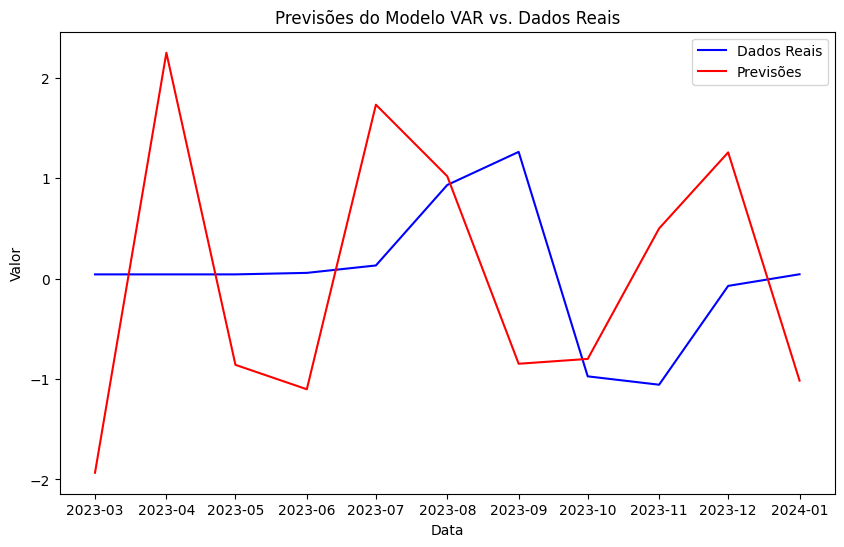

In [413]:
# Plotar as previsões e os dados reais
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['focuses'], label='Dados Reais', color='blue')
plt.plot(test.index, pred[:, 0], label='Previsões', color='red')
plt.title('Previsões do Modelo VAR vs. Dados Reais')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

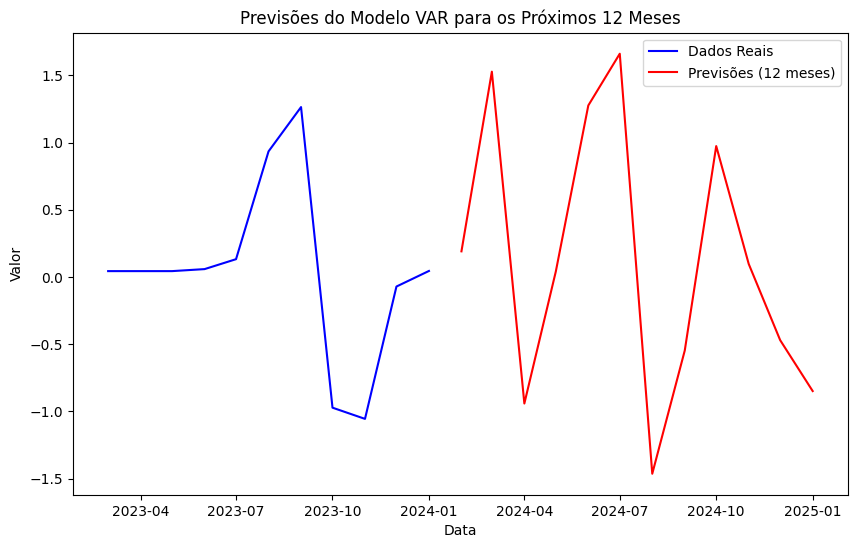

In [414]:
# Fazer previsões para os próximos 12 meses após o final do conjunto de teste
forecast_steps = 12
forecast = results.forecast(test[['focuses']].join(test[exog_cols]).values, steps=forecast_steps)

# Criar um índice para os próximos 12 meses
forecast_index = pd.date_range(start=test.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')

# Plotar as previsões para os próximos 12 meses
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['focuses'], label='Dados Reais', color='blue')
plt.plot(forecast_index, forecast[:, 0], label='Previsões (12 meses)', color='red')
plt.title('Previsões do Modelo VAR para os Próximos 12 Meses')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.show()

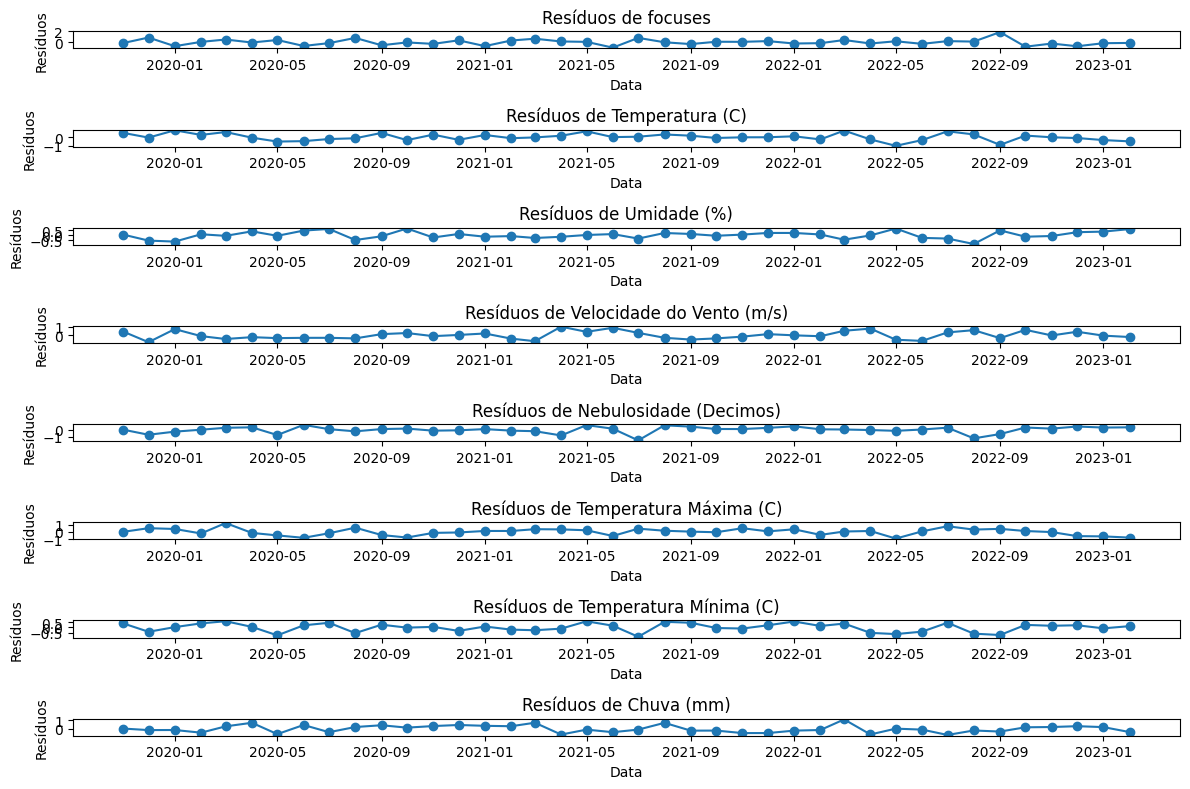

In [415]:
# Obter o número de variáveis no modelo VAR
num_vars = len(train.columns)

# Plotar os resíduos do modelo VAR
plt.figure(figsize=(12, 8))

# Loop sobre cada variável para plotar os resíduos
for i, var in enumerate(train.columns):
    plt.subplot(num_vars, 1, i + 1)
    plt.plot(results.resid.index, results.resid[var], marker='o', linestyle='-')
    plt.title(f'Resíduos de {var}')
    plt.xlabel('Data')
    plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()